# Create master dataset

In [ ]:
from datetime import timedelta
from google.cloud import bigquery
import pandas as pd
import numpy as np
import re
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import collections
from pandas.io import gbq
from sklearn.model_selection import train_test_split
import pickle
from sklearn.impute import SimpleImputer
import itertools

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

output_path = '/content/drive/MyDrive/mimic4_output'
os.makedirs(output_path, exist_ok=True)

Mounted at /content/drive


In [ ]:
# Create client
client = bigquery.Client(project='perfect-crow-472910-d7')

In [ ]:
# All the tables for easy accessibility
table_map = {
    # ICU tables
    "chartevents": "physionet-data.mimiciv_3_1_icu.chartevents",
    "datetimeevents": "physionet-data.mimiciv_3_1_icu.datetimeevents",
    "d_items": "physionet-data.mimiciv_3_1_icu.d_items",
    "icustays": "physionet-data.mimiciv_3_1_icu.icustays",
    "inputevents": "physionet-data.mimiciv_3_1_icu.inputevents",
    "outputevents": "physionet-data.mimiciv_3_1_icu.outputevents",
    "procedureevents": "physionet-data.mimiciv_3_1_icu.procedureevents",

    # Core tables
    "patients": "physionet-data.mimiciv_3_1_hosp.patients",
    "admissions": "physionet-data.mimiciv_3_1_hosp.admissions",
    "transfers": "physionet-data.mimiciv_3_1_hosp.transfers",

    # Hospital tables
    "d_hcpcs": "physionet-data.mimiciv_3_1_hosp.d_hcpcs",
    "d_icd_diagnoses": "physionet-data.mimiciv_3_1_hosp.d_icd_diagnoses",
    "d_labitems": "physionet-data.mimiciv_3_1_hosp.d_labitems",
    "emar": "physionet-data.mimiciv_3_1_hosp.emar",
    "hcpcsevents": "physionet-data.mimiciv_3_1_hosp.hcpcsevents",
    "microbiologyevents": "physionet-data.mimiciv_3_1_hosp.microbiologyevents",
    "poe": "physionet-data.mimiciv_3_1_hosp.poe",
    "prescriptions": "physionet-data.mimiciv_3_1_hosp.prescriptions",
    "services": "physionet-data.mimiciv_3_1_hosp.services",
    "diagnoses_icd": "physionet-data.mimiciv_3_1_hosp.diagnoses_icd",
    "d_icd_procedures": "physionet-data.mimiciv_3_1_hosp.d_icd_procedures",
    "drgcodes": "physionet-data.mimiciv_3_1_hosp.drgcodes",
    "emar_detail": "physionet-data.mimiciv_3_1_hosp.emar_detail",
    "labevents": "physionet-data.mimiciv_3_1_hosp.labevents",
    "pharmacy": "physionet-data.mimiciv_3_1_hosp.pharmacy",
    "poe_detail": "physionet-data.mimiciv_3_1_hosp.poe_detail",
    "procedures_icd": "physionet-data.mimiciv_3_1_hosp.procedures_icd",

    # ED tables
    "diagnosis": "physionet-data.mimiciv_ed.diagnosis",
    "edstays": "physionet-data.mimiciv_ed.edstays",
    "medrecon": "physionet-data.mimiciv_ed.medrecon",
    "pyxis": "physionet-data.mimiciv_ed.pyxis",
    "triage": "physionet-data.mimiciv_ed.triage",
    "vitalsign": "physionet-data.mimiciv_ed.vitalsign",

    # derived tables
    "sofa": "physionet-data.mimiciv_3_1_derived.sofa",
    "charlson": "physionet-data.mimiciv_3_1_derived.charlson",
    "ventilation": "physionet-data.mimiciv_3_1_derived.ventilation"
}


In [ ]:
def load_table(table_name, columns="*", where=None, limit=None):
    print(f"Loading: {table_name}")
    query = f"SELECT {columns} FROM `{table_map[table_name]}`"
    if where:
        query += f" WHERE {where}"
    if limit:
        query += f" LIMIT {limit}"
    return client.query(query).to_dataframe()

In [ ]:
# loading manageable tables (smaller)
df_icustays = load_table("icustays")
df_patients = load_table("patients")
df_admissions = load_table("admissions")
df_procedureevents = load_table("procedureevents")

Loading: icustays
Loading: patients
Loading: admissions
Loading: procedureevents


In [ ]:
stay_ids = tuple(df_icustays['stay_id'].unique())
hadm_ids = tuple(df_icustays['hadm_id'].unique())

In [ ]:
# query only a subset for larger tables (labevents and chartevents):
# keep only data linked to ICU stays, filter out nulls, keep only from first 24h,
# keep only relevant measurements and columns

lab_itemids = [
    # Renal/metabolic
    50912,  # Creatinine
    50931,  # Glucose
    50971,  # Potassium
    50983,  # Sodium
    51006,  # WBC
    51002,  # BUN
    50882,  # Bicarbonate

    # Hematologic
    51222,  # Hemoglobin
    51265,  # Platelets

    # Respiratory
    50813,  # Lactate

    # Liver
    50885,  # Bilirubin

    # Inflammation
    51256,  # Neutrophils

    # Arterial blood gases
    50820,  # pH
    50818,  # pCO2
    50821   # pO2
]

query = f"""
SELECT
  l.subject_id,
  l.hadm_id,
  l.itemid,
  l.charttime,
  l.valuenum
FROM `physionet-data.mimiciv_3_1_hosp.labevents` AS l
INNER JOIN `physionet-data.mimiciv_3_1_icu.icustays` AS i
ON l.hadm_id = i.hadm_id
WHERE l.valuenum IS NOT NULL
  AND l.itemid IN ({','.join(map(str, lab_itemids))})
  AND l.charttime BETWEEN i.intime AND TIMESTAMP_ADD(i.intime, INTERVAL 24 HOUR)
"""
df_labevents = client.query(query).to_dataframe()


In [ ]:
# corresponding to: heartrate, sbp, dbp, respiratory rate, temperature
vital_itemids = [211,220045,51,220179,8368,220180,618,220210,223761,678,223834,227287 ]

query = f"""
SELECT
  c.subject_id,
  c.hadm_id,
  c.stay_id,
  c.itemid,
  c.charttime,
  c.valuenum
FROM `physionet-data.mimiciv_3_1_icu.chartevents` AS c
INNER JOIN `physionet-data.mimiciv_3_1_icu.icustays` AS i
ON c.stay_id = i.stay_id
WHERE c.valuenum IS NOT NULL
  AND c.itemid IN ({','.join(map(str,vital_itemids))})
  AND c.charttime BETWEEN i.intime AND TIMESTAMP_ADD(i.intime, INTERVAL 24 HOUR)
"""
df_chartevents = client.query(query).to_dataframe()

# Define IMV Label

In [ ]:
# keep first ICU stay only
df_icustays = df_icustays.drop_duplicates(subset='subject_id', keep='first')

In [ ]:
df_ventilation = load_table("ventilation")

Loading: ventilation


ventilation_status
SupplementalOxygen    83826
InvasiveVent          46034
Tracheostomy           5286
NonInvasiveVent        4832
HFNC                   4746
None                    197
Name: count, dtype: int64


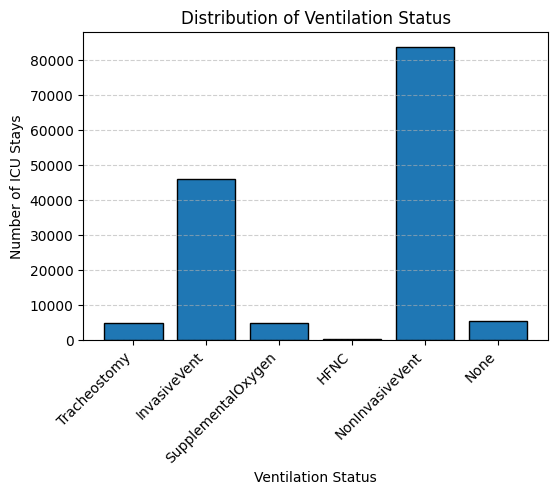

In [ ]:
print(df_ventilation['ventilation_status'].value_counts())
counts = df_ventilation['ventilation_status'].value_counts().sort_index()
labels = ['Tracheostomy', 'InvasiveVent', 'SupplementalOxygen', 'HFNC', 'NonInvasiveVent', 'None']

plt.figure(figsize=(6, 4))
plt.bar(labels, counts, edgecolor='black')
plt.title('Distribution of Ventilation Status')
plt.ylabel('Number of ICU Stays')
plt.xlabel('Ventilation Status')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [ ]:
# Invasive Mechanical Ventilation - Label IMV if it occurs within first 48 hours

# Merge ventilation with icustays to get intime
df_ventilation_with_time = df_ventilation.merge(
    df_icustays[['stay_id', 'intime']],
    on='stay_id',
    how='left'
)

# Calculate hours from ICU admission to ventilation start
df_ventilation_with_time['hours_to_vent'] = (
    (df_ventilation_with_time['starttime'] - df_ventilation_with_time['intime'])
    .dt.total_seconds() / 3600
)

# Label as IMV=1 only if ventilation started within first 48 hours
df_imv = df_ventilation_with_time[
    (df_ventilation_with_time['ventilation_status'].isin(['InvasiveVent', 'Tracheostomy'])) &
    (df_ventilation_with_time['hours_to_vent'] <= 48)
]
df_imv_label = df_imv[['stay_id']].drop_duplicates().assign(imv=1)

# Merge labels
df_icustays = df_icustays.merge(df_imv_label, on='stay_id', how='left')
df_icustays['imv'] = df_icustays['imv'].fillna(0).astype(int)

print(f"Patients with IMV within first 48h: {df_icustays['imv'].sum()} ({df_icustays['imv'].mean():.1%})")

# Check the distribution of ventilation timing
print("\nDistribution of hours to ventilation:")
print(df_imv['hours_to_vent'].describe())

Patients with IMV within first 48h: 23644 (36.2%)

Distribution of hours to ventilation:
count    24657.000000
mean         4.896452
std         10.745437
min       -336.261667
25%          0.203611
50%          1.633333
75%          4.480278
max         48.000000
Name: hours_to_vent, dtype: float64


imv
0    41722
1    23644
Name: count, dtype: int64


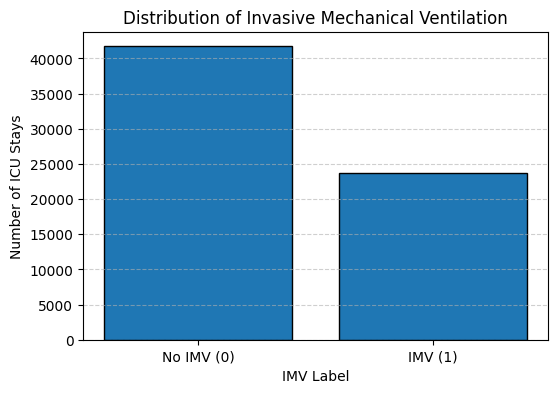

In [ ]:
print(df_icustays['imv'].value_counts())

# Plot distribution
counts = df_icustays['imv'].value_counts().sort_index()
labels = ['No IMV (0)', 'IMV (1)']

plt.figure(figsize=(6, 4))
plt.bar(labels, counts, edgecolor='black')
plt.title('Distribution of Invasive Mechanical Ventilation')
plt.ylabel('Number of ICU Stays')
plt.xlabel('IMV Label')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

~ 63/37 (not Invasively mechanically ventilated vs invasively mechanically ventilated)

~ 59/41 (not mechanically ventilated vs mechanically ventilated)


# Add demographics and admission info

In [ ]:
df_icustays

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,imv
0,10270110,20171261,35854639,PACU,PACU,2134-03-25 03:32:02,2134-03-25 14:20:42,0.450463,0
1,10270644,20019675,35548343,PACU,PACU,2159-12-03 16:20:31,2159-12-08 17:28:42,5.047350,0
2,10368426,21588639,39194905,PACU,PACU,2164-12-30 13:29:21,2164-12-30 14:00:38,0.021725,0
3,10464753,28216499,32421516,PACU,PACU,2183-01-10 20:51:04,2183-01-11 22:58:45,1.088669,1
4,10640410,25898987,34344828,PACU,PACU,2112-02-03 12:55:23,2112-02-08 15:14:54,5.096887,1
...,...,...,...,...,...,...,...,...,...
65361,19992556,22023649,35141145,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2144-12-25 00:38:00,2144-12-26 14:24:59,1.574294,0
65362,19995179,22929215,34899707,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2124-09-09 19:26:56,2124-09-10 11:16:40,0.659537,0
65363,19996432,29434165,36469520,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2111-11-13 09:06:00,2111-11-14 18:44:57,1.402049,0
65364,19999068,21606769,30143796,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2161-08-24 05:26:00,2161-08-30 23:48:04,6.765324,1


In [ ]:
# Start with ICU stays + IMV label
cohort = df_icustays.copy()

# Merge demographics from patients table
cohort = cohort.merge(
    df_patients[['subject_id', 'gender', 'anchor_age', 'anchor_year']],
    on='subject_id',
    how='left'
)

# Age in MIMIC-IV is: anchor_age + (admit_year - anchor_year)
cohort['age'] = (
    cohort['intime'].dt.year
    - cohort['anchor_year']
    + cohort['anchor_age']
)
cohort = cohort.drop(columns=['anchor_age', 'anchor_year'])

# Merge admission info (race, insurance, language, admission_type)
cohort = cohort.merge(
    df_admissions[['hadm_id', 'insurance', 'language', 'race', 'admission_type', 'marital_status']],
    on='hadm_id',
    how='left'
)

# Recode variables
#cohort['language_english'] = (cohort['language'] == 'English').astype(int)
cohort['elective_admission'] = cohort['admission_type'].str.lower().str.contains('elective').astype(int)


In [ ]:
race_dic = {
    # White group
    'WHITE': '@White',
    'WHITE - OTHER EUROPEAN': '@White',
    'WHITE - BRAZILIAN': '@White',
    'WHITE - RUSSIAN': '@White',
    'WHITE - EASTERN EUROPEAN': '@White',

    # Black group
    'BLACK/AFRICAN AMERICAN': 'Black',
    'BLACK/AFRICAN': 'Black',
    'BLACK/CAPE VERDEAN': 'Black',
    'BLACK/CARIBBEAN ISLAND': 'Black',

    # Asian group
    'ASIAN': 'Asian',
    'ASIAN - CHINESE': 'Asian',
    'ASIAN - ASIAN INDIAN': 'Asian',
    'ASIAN - SOUTH EAST ASIAN': 'Asian',
    'ASIAN - KOREAN': 'Asian',

    # Hispanic/Latino group
    'HISPANIC/LATINO - COLUMBIAN': 'Hispanic',
    'HISPANIC/LATINO - DOMINICAN': 'Hispanic',
    'HISPANIC/LATINO - PUERTO RICAN': 'Hispanic',
    'HISPANIC OR LATINO': 'Hispanic',
    'HISPANIC/LATINO - GUATEMALAN': 'Hispanic',
    'HISPANIC/LATINO - HONDURAN': 'Hispanic',
    'HISPANIC/LATINO - SALVADORAN': 'Hispanic',
    'HISPANIC/LATINO - CENTRAL AMERICAN': 'Hispanic',
    'HISPANIC/LATINO - CUBAN': 'Hispanic',
    'HISPANIC/LATINO - MEXICAN': 'Hispanic',

    # Others / Uncategorized
    'OTHER': 'Other',
    'PATIENT DECLINED TO ANSWER': 'Unknown',
    'UNKNOWN': 'Unknown',
    'UNABLE TO OBTAIN': 'Unknown',
    'MULTIPLE RACE/ETHNICITY': 'Other',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'Other',
    'AMERICAN INDIAN/ALASKA NATIVE': 'Other',
    'SOUTH AMERICAN': 'Other',
    'PORTUGUESE': 'Other'
}

cohort['race'] = cohort['race'].map(race_dic)
cohort['race'] = cohort['race'].fillna('Unknown')


In [ ]:
#sex
sex_dic = {
    'M': '@Male',
    'F': 'Female',
}

cohort["sex"] = cohort["gender"].astype(str).str.strip().str.upper().map(sex_dic)
cohort.drop('gender', axis=1, inplace=True)


#language
top_languages = cohort['language'].value_counts().nlargest(5).index.tolist()

# Map top languages to themselves (or custom labels), others → 'Other'
def map_language(lang):
    lang = str(lang).strip()
    if lang in top_languages:
        # Optionally add "@" prefix for English if you want consistency
        return '@English' if lang == 'English' else lang
    else:
        return 'Other'

cohort['language'] = cohort['language'].apply(map_language)

# insurance
insurance_dic = {
    'Private': '@Private',
    'Medicare': 'Medicare',
    'Medicaid': 'Medicaid',
    'No charge': 'Other',
    'Other': 'Other'
}

cohort["insurance"] = cohort["insurance"].str.strip().map(insurance_dic)
cohort['insurance'] = cohort['insurance'].fillna('Other')



#marital status
marital_map = {
    'MARRIED': '@Married',
    'SINGLE': 'Single',
    'DIVORCED': 'Divorced',
    'WIDOWED': 'Widowed'
}

cohort['marital_status'] = cohort['marital_status'].str.strip().str.upper().map(marital_map)
cohort['marital_status'] = cohort['marital_status'].fillna('Unknown')



In [ ]:
cohort

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,imv,age,insurance,language,race,admission_type,marital_status,elective_admission,sex
0,10270110,20171261,35854639,PACU,PACU,2134-03-25 03:32:02,2134-03-25 14:20:42,0.450463,0,78,Medicaid,@English,@White,EW EMER.,@Married,0,@Male
1,10270644,20019675,35548343,PACU,PACU,2159-12-03 16:20:31,2159-12-08 17:28:42,5.047350,0,91,Medicare,@English,@White,EW EMER.,Divorced,0,Female
2,10368426,21588639,39194905,PACU,PACU,2164-12-30 13:29:21,2164-12-30 14:00:38,0.021725,0,90,Medicare,@English,@White,EW EMER.,Widowed,0,@Male
3,10464753,28216499,32421516,PACU,PACU,2183-01-10 20:51:04,2183-01-11 22:58:45,1.088669,1,87,Medicare,@English,Unknown,OBSERVATION ADMIT,@Married,0,@Male
4,10640410,25898987,34344828,PACU,PACU,2112-02-03 12:55:23,2112-02-08 15:14:54,5.096887,1,44,@Private,@English,Black,OBSERVATION ADMIT,@Married,0,Female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65361,19992556,22023649,35141145,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2144-12-25 00:38:00,2144-12-26 14:24:59,1.574294,0,26,Medicaid,@English,Hispanic,EW EMER.,Single,0,@Male
65362,19995179,22929215,34899707,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2124-09-09 19:26:56,2124-09-10 11:16:40,0.659537,0,54,@Private,@English,@White,DIRECT OBSERVATION,@Married,0,Female
65363,19996432,29434165,36469520,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2111-11-13 09:06:00,2111-11-14 18:44:57,1.402049,0,60,Medicare,@English,@White,EW EMER.,Single,0,@Male
65364,19999068,21606769,30143796,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2161-08-24 05:26:00,2161-08-30 23:48:04,6.765324,1,63,Medicare,@English,@White,EW EMER.,Divorced,0,@Male



=== SEX ===
sex
@Male     36720
Female    28646
Name: count, dtype: int64


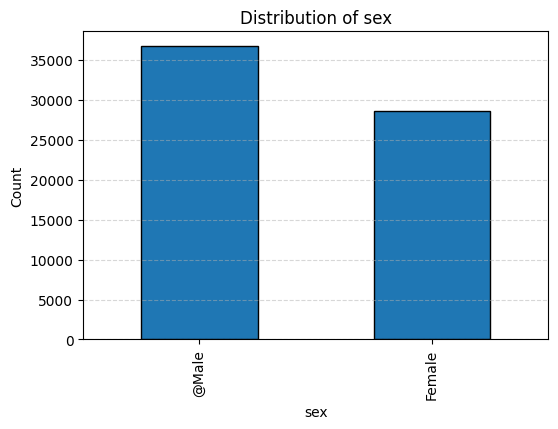


=== RACE ===
race
@White      43015
Unknown      9216
Black        6032
Other        2821
Hispanic     2293
Asian        1989
Name: count, dtype: int64


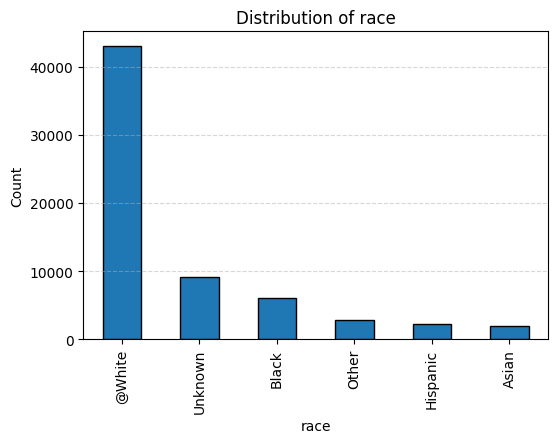


=== INSURANCE ===
insurance
Medicare    34824
@Private    18115
Medicaid     9384
Other        3043
Name: count, dtype: int64


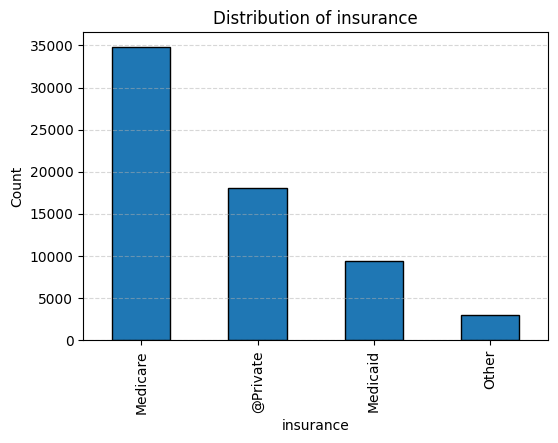


=== LANGUAGE ===
language
@English      59076
Other          2312
Spanish        1921
Chinese         828
Russian         752
Portuguese      477
Name: count, dtype: int64


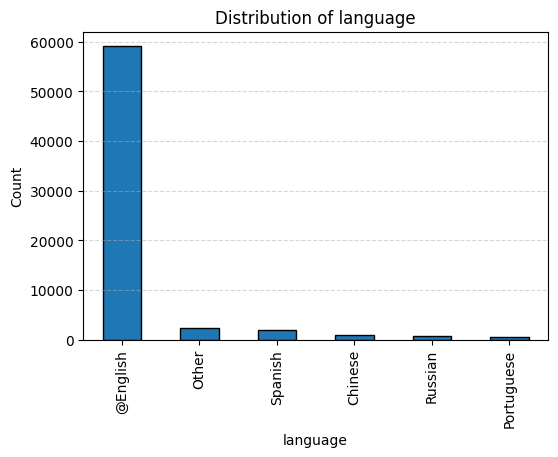


=== MARITAL_STATUS ===
marital_status
@Married    29188
Single      17386
Widowed      7603
Unknown      6613
Divorced     4576
Name: count, dtype: int64


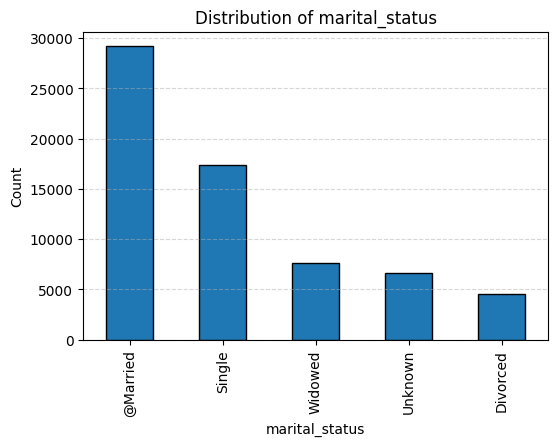

In [ ]:
protected_attrs = ["sex", "race", "insurance", "language", 'marital_status']

for attr in protected_attrs:
    print(f"\n=== {attr.upper()} ===")
    print(cohort[attr].value_counts(dropna=False))

    plt.figure(figsize=(6,4))
    cohort[attr].value_counts(dropna=False).plot(kind='bar', edgecolor='black')
    plt.title(f"Distribution of {attr}")
    plt.ylabel("Count")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

Insurance distinctions:
- Medicare: mainly adults 65+, U.S. federal insurance
- Medicaid: low-income patients, government-funded but state-managed
- Private: indicates higher socioeconomic status
- Other: military, international, etc.
- None: uninsured
- No charge: hospital doesn't bill patient

In [ ]:
# remove samples with Unknown race
cohort = cohort[cohort['race'] != 'Unknown']


=== SEX ===


imv,0,1
sex,,
@Male,63.260059,36.739941
Female,70.468163,29.531837


<Figure size 700x500 with 0 Axes>

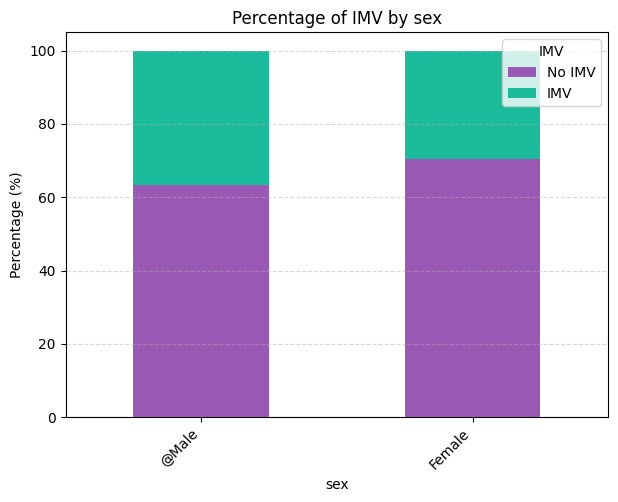


=== RACE ===


imv,0,1
race,,
@White,66.032779,33.967221
Asian,68.124686,31.875314
Black,70.988064,29.011936
Hispanic,66.070650,33.929350
Other,62.708259,37.291741


<Figure size 700x500 with 0 Axes>

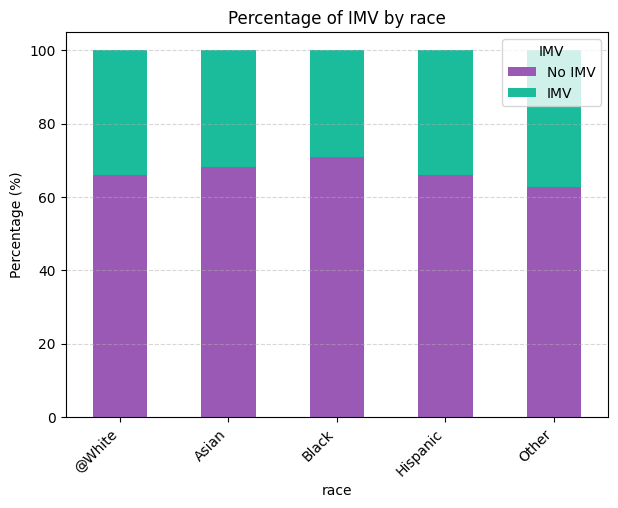


=== INSURANCE ===


imv,0,1
insurance,,
@Private,66.399949,33.600051
Medicaid,66.269791,33.730209
Medicare,66.748898,33.251102
Other,63.962349,36.037651


<Figure size 700x500 with 0 Axes>

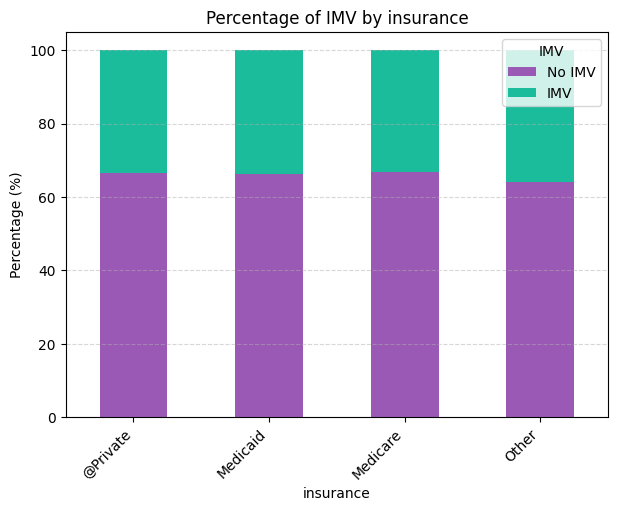


=== LANGUAGE ===


imv,0,1
language,,
@English,66.361151,33.638849
Chinese,70.812183,29.187817
Other,66.416309,33.583691
Portuguese,65.395095,34.604905
Russian,72.390110,27.609890
Spanish,65.512821,34.487179


<Figure size 700x500 with 0 Axes>

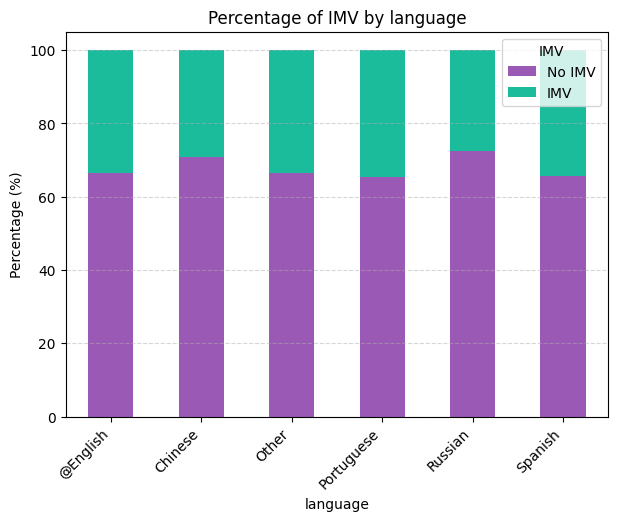


=== MARITAL_STATUS ===


imv,0,1
marital_status,,
@Married,65.335422,34.664578
Divorced,66.287703,33.712297
Single,67.449829,32.550171
Unknown,51.705321,48.294679
Widowed,71.606821,28.393179


<Figure size 700x500 with 0 Axes>

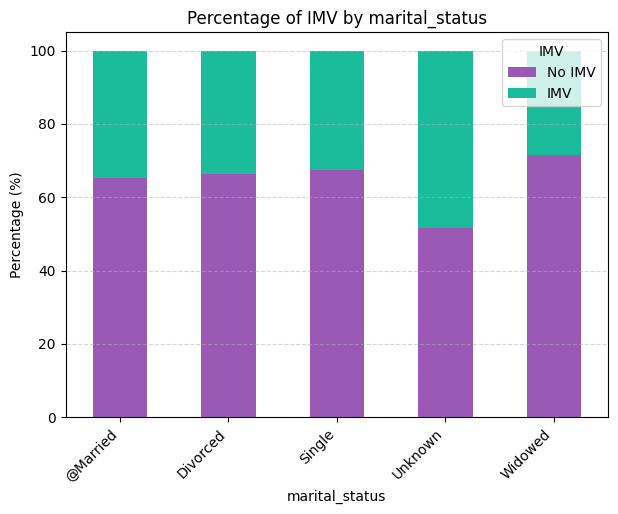

In [ ]:
protected_attrs = ["sex", "race", "insurance", "language", "marital_status"]

for attr in protected_attrs:
    print(f"\n=== {attr.upper()} ===")

    # Crosstab: counts
    ct = pd.crosstab(cohort[attr], cohort['imv'])

    # Convert to row percentages
    pct = ct.div(ct.sum(axis=1), axis=0) * 100

    # Print table
    display(pct)

    # Plot
    plt.figure(figsize=(7,5))
    pct.plot(kind='bar', stacked=True, figsize=(7,5), color=['#9b59b6', '#1abc9c'])

    plt.title(f"Percentage of IMV by {attr}")
    plt.ylabel("Percentage (%)")
    plt.legend(["No IMV", "IMV"], title="IMV", loc="upper right")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.xticks(rotation=45, ha="right")

    plt.show()


# Add Commorbidity Flags

In [ ]:
# Example ICD-10 code prefixes for comorbidities (simplified)
conditions = {
    'hypertension': ['I10', 'I11', 'I12', 'I13'],
    'congestive_heart_failure': ['I50'],
    'copd': ['J44'],
    'asthma': ['J45'],
    'coronary_artery_disease': ['I25'],
    'chronic_kidney_disease': ['N18'],
    'diabetes': ['E10', 'E11'],
    'connective_tissue_disease': ['M05', 'M06']
}

df_diagnoses = load_table("diagnoses_icd")

# Normalize ICD column name
df_diagnoses = df_diagnoses.rename(columns={
    'icd10_code': 'icd_code',
    'code': 'icd_code'
})

# Flag ICD codes for each comorbidity
for cond, codes in conditions.items():
    df_diagnoses[cond] = df_diagnoses['icd_code'].str.startswith(tuple(codes)).astype(int)

# Aggregate ONE row per hadm_id
comorb = df_diagnoses.groupby('hadm_id')[list(conditions.keys())].max().reset_index()

# Merge safely (WILL NOT expand rows)
cohort = cohort.merge(comorb, on='hadm_id', how='left').fillna(0)


#SOFA is Sequential Organ Failure Assessment
sofa = client.query("SELECT stay_id, sofa_24hours FROM `physionet-data.mimiciv_3_1_derived.sofa`").to_dataframe()
charlson = client.query("SELECT hadm_id, charlson_comorbidity_index FROM `physionet-data.mimiciv_3_1_derived.charlson`").to_dataframe()

# Keep only one row per stay_id / hadm_id
sofa_unique = sofa.groupby('stay_id', as_index=False).max()  # or mean(), or first()
charlson_unique = charlson.groupby('hadm_id', as_index=False).max()

cohort = (cohort
          .merge(sofa_unique, on='stay_id', how='left')
          .merge(charlson_unique, on='hadm_id', how='left'))


Loading: diagnoses_icd


In [ ]:
cohort

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,imv,age,...,hypertension,congestive_heart_failure,copd,asthma,coronary_artery_disease,chronic_kidney_disease,diabetes,connective_tissue_disease,sofa_24hours,charlson_comorbidity_index
0,10270110,20171261,35854639,PACU,PACU,2134-03-25 03:32:02,2134-03-25 14:20:42,0.450463,0,78,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,10
1,10270644,20019675,35548343,PACU,PACU,2159-12-03 16:20:31,2159-12-08 17:28:42,5.047350,0,91,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3,5
2,10368426,21588639,39194905,PACU,PACU,2164-12-30 13:29:21,2164-12-30 14:00:38,0.021725,0,90,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,6
3,10640410,25898987,34344828,PACU,PACU,2112-02-03 12:55:23,2112-02-08 15:14:54,5.096887,1,44,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6,2
4,10691194,24438843,37799251,PACU,PACU,2147-06-01 17:38:48,2147-06-01 17:58:44,0.013843,0,77,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,4,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56145,19992556,22023649,35141145,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2144-12-25 00:38:00,2144-12-26 14:24:59,1.574294,0,26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
56146,19995179,22929215,34899707,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2124-09-09 19:26:56,2124-09-10 11:16:40,0.659537,0,54,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
56147,19996432,29434165,36469520,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2111-11-13 09:06:00,2111-11-14 18:44:57,1.402049,0,60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,3
56148,19999068,21606769,30143796,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2161-08-24 05:26:00,2161-08-30 23:48:04,6.765324,1,63,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,3


# Add vitals and labs (first 24h averages)

In [ ]:
vital_itemids = {
    'heart_rate': [211, 220045],
    'sbp': [51, 220179],
    'dbp': [8368, 220180],
    'resp_rate': [618, 220210],
    'temperature': [223761, 678]
}

vitals = df_chartevents[df_chartevents['itemid'].isin(sum(vital_itemids.values(), []))]
vitals = vitals.merge(df_icustays[['stay_id', 'intime']], on='stay_id', how='left')
vitals = vitals[vitals['charttime'].between(vitals['intime'], vitals['intime'] + pd.Timedelta(hours=24))]

feat_list = []
for name, ids in vital_itemids.items():
    temp = vitals[vitals['itemid'].isin(ids)].groupby('stay_id')['valuenum'].mean().reset_index().rename(columns={'valuenum': name})
    feat_list.append(temp)

vitals_summary = feat_list[0]
for temp in feat_list[1:]:
    vitals_summary = vitals_summary.merge(temp, on='stay_id', how='outer')

cohort = cohort.merge(vitals_summary, on='stay_id', how='left')


# Temperature Conversion + Outlier Removal

In [ ]:
vitals_valid_range = {
    'temperature': {'outlier_low': 14.2, 'valid_low': 26, 'valid_high': 45, 'outlier_high':47},
    'heart_rate': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 350, 'outlier_high':390},
    'resp_rate': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 300, 'outlier_high':330},
    'sbp': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 375, 'outlier_high':375},
    'dbp': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 375, 'outlier_high':375},
}


In [ ]:
def convert_temp_to_celcius(df):
    if 'temperature' in df.columns:
        df['temperature'] = (df['temperature'] - 32) * (5/9)
    return df

def outlier_removal_imputation(column_type, vitals_valid_range):
    column_range = vitals_valid_range[column_type]
    def outlier_removal_imputation_single_value(x):
      if x is None or (isinstance(x, float) and np.isnan(x)):
          return np.nan  # or keep as is
      if x < column_range['outlier_low'] or x > column_range['outlier_high']:
          return np.nan
      elif x < column_range['valid_low']:
          return column_range['valid_low']
      elif x > column_range['valid_high']:
          return column_range['valid_high']
      else:
          return x
    return outlier_removal_imputation_single_value

def remove_outliers(df, vitals_valid_range):
    for column in df.columns:
        if column in vitals_valid_range:
            if pd.api.types.is_numeric_dtype(df[column]):
                fn = outlier_removal_imputation(column, vitals_valid_range)
                df[column] = df[column].apply(fn)
    return df


def display_outliers_count(df, vitals_valid_range):
    rows = []
    for column in df.columns:
        if column in vitals_valid_range:
            rng = vitals_valid_range[column]

            row = {
                'variable': column,
                '< outlier_low': len(df[df[column] < rng['outlier_low']]),
                '[outlier_low, valid_low)': len(df[(rng['outlier_low'] <= df[column]) &
                                                   (df[column] < rng['valid_low'])]),
                '[valid_low, valid_high]': len(df[(rng['valid_low'] <= df[column]) &
                                                  (df[column] <= rng['valid_high'])]),
                '(valid_high, outlier_high]': len(df[(rng['valid_high'] < df[column]) &
                                                     (df[column] <= rng['outlier_high'])]),
                '> outlier_high': len(df[df[column] > rng['outlier_high']])
            }
            rows.append(row)
    return pd.DataFrame(rows)



In [ ]:
cohort = convert_temp_to_celcius(cohort)

In [ ]:
display_outliers_count(cohort, vitals_valid_range)

,variable,< outlier_low,"[outlier_low, valid_low)","[valid_low, valid_high]","(valid_high, outlier_high]",> outlier_high
0,heart_rate,0,0,56088,0,2
1,sbp,0,0,51416,0,7
2,dbp,0,0,51385,0,31
3,resp_rate,0,0,55945,0,2
4,temperature,49,43,52480,0,20


In [ ]:
cohort = remove_outliers(cohort, vitals_valid_range)

In [ ]:
list(cohort.columns)

['subject_id',
 'hadm_id',
 'stay_id',
 'first_careunit',
 'last_careunit',
 'intime',
 'outtime',
 'los',
 'imv',
 'age',
 'insurance',
 'language',
 'race',
 'admission_type',
 'marital_status',
 'elective_admission',
 'sex',
 'hypertension',
 'congestive_heart_failure',
 'copd',
 'asthma',
 'coronary_artery_disease',
 'chronic_kidney_disease',
 'diabetes',
 'connective_tissue_disease',
 'sofa_24hours',
 'charlson_comorbidity_index',
 'heart_rate',
 'sbp',
 'dbp',
 'resp_rate',
 'temperature']

# Download .csv file

In [ ]:
cohort.to_csv("cohort.csv", index=False)

from google.colab import files
files.download("cohort.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Train-val-test split

In [ ]:
# Create 70/10/20 split
dat_train, temp_df = train_test_split(cohort, test_size=0.3, random_state=42)
dat_expl, dat_test = train_test_split(temp_df, test_size=2/3, random_state=42)

In [ ]:
print('Training dataset size = ', len(dat_train))
print('Validation dataset size = ', len(dat_expl))
print('Testing dataset size = ', len(dat_test))

Training dataset size =  39305
Validation dataset size =  5615
Testing dataset size =  11230


# Missing Value Imputation

In [ ]:
vitals_cols = ['temperature','heart_rate','resp_rate','sbp','dbp','sofa_24hours']
imputer = SimpleImputer(strategy='median') #median for continuous and numeric

dat_train[vitals_cols] = imputer.fit_transform(dat_train[vitals_cols])
dat_expl[vitals_cols] = imputer.transform(dat_expl[vitals_cols])
dat_test[vitals_cols] = imputer.transform(dat_test[vitals_cols])

# Comprehensive Cohort Statistics


In [ ]:
# Comprehensive Cohort Statistics Table
print("=" * 80)
print("COMPREHENSIVE COHORT STATISTICS")
print("=" * 80)

# Create summary statistics table
stats_data = []

# Overall cohort
stats_data.append({
    'Group': 'Overall',
    'Subgroup': 'All',
    'N': len(cohort),
    'IMV Rate (%)': f"{cohort['imv'].mean()*100:.2f}",
    'Age (mean±std)': f"{cohort['age'].mean():.1f}±{cohort['age'].std():.1f}",
    'Hypertension (%)': f"{cohort['hypertension'].mean()*100:.1f}",
    'CHF (%)': f"{cohort['congestive_heart_failure'].mean()*100:.1f}",
    'COPD (%)': f"{cohort['copd'].mean()*100:.1f}",
    'CAD (%)': f"{cohort['coronary_artery_disease'].mean()*100:.1f}",
    'CKD (%)': f"{cohort['chronic_kidney_disease'].mean()*100:.1f}",
    'Diabetes (%)': f"{cohort['diabetes'].mean()*100:.1f}",
    'SOFA (mean±std)': f"{cohort['sofa_24hours'].mean():.2f}±{cohort['sofa_24hours'].std():.2f}",
    'Charlson (mean±std)': f"{cohort['charlson_comorbidity_index'].mean():.2f}±{cohort['charlson_comorbidity_index'].std():.2f}",
    'HR (mean±std)': f"{cohort['heart_rate'].mean():.1f}±{cohort['heart_rate'].std():.1f}",
    'Temp (mean±std)': f"{cohort['temperature'].mean():.2f}±{cohort['temperature'].std():.2f}",
    'RR (mean±std)': f"{cohort['resp_rate'].mean():.1f}±{cohort['resp_rate'].std():.1f}",
    'SBP (mean±std)': f"{cohort['sbp'].mean():.1f}±{cohort['sbp'].std():.1f}",
    'DBP (mean±std)': f"{cohort['dbp'].mean():.1f}±{cohort['dbp'].std():.1f}"
})

# By Sex
for sex in cohort['sex'].unique():
    subset = cohort[cohort['sex'] == sex]
    stats_data.append({
        'Group': 'Sex',
        'Subgroup': sex,
        'N': len(subset),
        'IMV Rate (%)': f"{subset['imv'].mean()*100:.2f}",
        'Age (mean±std)': f"{subset['age'].mean():.1f}±{subset['age'].std():.1f}",
        'Hypertension (%)': f"{subset['hypertension'].mean()*100:.1f}",
        'CHF (%)': f"{subset['congestive_heart_failure'].mean()*100:.1f}",
        'COPD (%)': f"{subset['copd'].mean()*100:.1f}",
        'CAD (%)': f"{subset['coronary_artery_disease'].mean()*100:.1f}",
        'CKD (%)': f"{subset['chronic_kidney_disease'].mean()*100:.1f}",
        'Diabetes (%)': f"{subset['diabetes'].mean()*100:.1f}",
        'SOFA (mean±std)': f"{subset['sofa_24hours'].mean():.2f}±{subset['sofa_24hours'].std():.2f}",
        'Charlson (mean±std)': f"{subset['charlson_comorbidity_index'].mean():.2f}±{subset['charlson_comorbidity_index'].std():.2f}",
        'HR (mean±std)': f"{subset['heart_rate'].mean():.1f}±{subset['heart_rate'].std():.1f}",
        'Temp (mean±std)': f"{subset['temperature'].mean():.2f}±{subset['temperature'].std():.2f}",
        'RR (mean±std)': f"{subset['resp_rate'].mean():.1f}±{subset['resp_rate'].std():.1f}",
        'SBP (mean±std)': f"{subset['sbp'].mean():.1f}±{subset['sbp'].std():.1f}",
        'DBP (mean±std)': f"{subset['dbp'].mean():.1f}±{subset['dbp'].std():.1f}"
    })

# By Race
for race in cohort['race'].unique():
    subset = cohort[cohort['race'] == race]
    stats_data.append({
        'Group': 'Race',
        'Subgroup': race,
        'N': len(subset),
        'IMV Rate (%)': f"{subset['imv'].mean()*100:.2f}",
        'Age (mean±std)': f"{subset['age'].mean():.1f}±{subset['age'].std():.1f}",
        'Hypertension (%)': f"{subset['hypertension'].mean()*100:.1f}",
        'CHF (%)': f"{subset['congestive_heart_failure'].mean()*100:.1f}",
        'COPD (%)': f"{subset['copd'].mean()*100:.1f}",
        'CAD (%)': f"{subset['coronary_artery_disease'].mean()*100:.1f}",
        'CKD (%)': f"{subset['chronic_kidney_disease'].mean()*100:.1f}",
        'Diabetes (%)': f"{subset['diabetes'].mean()*100:.1f}",
        'SOFA (mean±std)': f"{subset['sofa_24hours'].mean():.2f}±{subset['sofa_24hours'].std():.2f}",
        'Charlson (mean±std)': f"{subset['charlson_comorbidity_index'].mean():.2f}±{subset['charlson_comorbidity_index'].std():.2f}",
        'HR (mean±std)': f"{subset['heart_rate'].mean():.1f}±{subset['heart_rate'].std():.1f}",
        'Temp (mean±std)': f"{subset['temperature'].mean():.2f}±{subset['temperature'].std():.2f}",
        'RR (mean±std)': f"{subset['resp_rate'].mean():.1f}±{subset['resp_rate'].std():.1f}",
        'SBP (mean±std)': f"{subset['sbp'].mean():.1f}±{subset['sbp'].std():.1f}",
        'DBP (mean±std)': f"{subset['dbp'].mean():.1f}±{subset['dbp'].std():.1f}"
    })

# By Sex × Race (Intersectional)
for sex in cohort['sex'].unique():
    for race in cohort['race'].unique():
        subset = cohort[(cohort['sex'] == sex) & (cohort['race'] == race)]
        if len(subset) > 0:
            stats_data.append({
                'Group': 'Sex × Race',
                'Subgroup': f"{sex} × {race}",
                'N': len(subset),
                'IMV Rate (%)': f"{subset['imv'].mean()*100:.2f}",
                'Age (mean±std)': f"{subset['age'].mean():.1f}±{subset['age'].std():.1f}",
                'Hypertension (%)': f"{subset['hypertension'].mean()*100:.1f}",
                'CHF (%)': f"{subset['congestive_heart_failure'].mean()*100:.1f}",
                'COPD (%)': f"{subset['copd'].mean()*100:.1f}",
                'CAD (%)': f"{subset['coronary_artery_disease'].mean()*100:.1f}",
                'CKD (%)': f"{subset['chronic_kidney_disease'].mean()*100:.1f}",
                'Diabetes (%)': f"{subset['diabetes'].mean()*100:.1f}",
                'SOFA (mean±std)': f"{subset['sofa_24hours'].mean():.2f}±{subset['sofa_24hours'].std():.2f}",
                'Charlson (mean±std)': f"{subset['charlson_comorbidity_index'].mean():.2f}±{subset['charlson_comorbidity_index'].std():.2f}",
                'HR (mean±std)': f"{subset['heart_rate'].mean():.1f}±{subset['heart_rate'].std():.1f}",
                'Temp (mean±std)': f"{subset['temperature'].mean():.2f}±{subset['temperature'].std():.2f}",
                'RR (mean±std)': f"{subset['resp_rate'].mean():.1f}±{subset['resp_rate'].std():.1f}",
                'SBP (mean±std)': f"{subset['sbp'].mean():.1f}±{subset['sbp'].std():.1f}",
                'DBP (mean±std)': f"{subset['dbp'].mean():.1f}±{subset['dbp'].std():.1f}"
            })

# Create DataFrame
stats_df = pd.DataFrame(stats_data)

# Display table
print("\nTable 1: Cohort Characteristics by Sex, Race, and Their Intersections")
print("="*80)
display(stats_df)

# Save to CSV
stats_df.to_csv(os.path.join(output_path, 'cohort_statistics_table.csv'), index=False)
print(f"\nTable saved to: {output_path}/cohort_statistics_table.csv")

# Dataset splits summary
print("\n" + "=" * 80)
print("DATASET SPLITS")
print("=" * 80)
splits_data = [
    {
        'Split': 'Training',
        'N': len(dat_train),
        'Percentage': f"{len(dat_train)/len(cohort)*100:.1f}%",
        'IMV Count': dat_train['imv'].sum(),
        'IMV Rate': f"{dat_train['imv'].mean()*100:.2f}%"
    },
    {
        'Split': 'Validation',
        'N': len(dat_expl),
        'Percentage': f"{len(dat_expl)/len(cohort)*100:.1f}%",
        'IMV Count': dat_expl['imv'].sum(),
        'IMV Rate': f"{dat_expl['imv'].mean()*100:.2f}%"
    },
    {
        'Split': 'Test',
        'N': len(dat_test),
        'Percentage': f"{len(dat_test)/len(cohort)*100:.1f}%",
        'IMV Count': dat_test['imv'].sum(),
        'IMV Rate': f"{dat_test['imv'].mean()*100:.2f}%"
    }
]
splits_df = pd.DataFrame(splits_data)
display(splits_df)
print("=" * 80)

COMPREHENSIVE COHORT STATISTICS

Table 1: Cohort Characteristics by Sex, Race, and Their Intersections


,Group,Subgroup,N,IMV Rate (%),Age (mean±std),Hypertension (%),CHF (%),COPD (%),CAD (%),CKD (%),Diabetes (%),SOFA (mean±std),Charlson (mean±std),HR (mean±std),Temp (mean±std),RR (mean±std),SBP (mean±std),DBP (mean±std)
0,Overall,All,56150,33.53,65.2±16.9,33.9,12.8,6.1,15.6,10.5,15.2,4.57±3.60,4.81±3.06,84.1±16.0,36.82±0.60,19.0±3.9,118.3±17.8,65.9±13.4
1,Sex,@Male,31116,36.74,64.4±16.2,35.2,13.0,5.8,19.6,11.8,16.3,4.83±3.66,4.81±3.11,83.4±15.9,36.83±0.62,18.9±4.0,118.7±17.6,67.2±13.4
2,Sex,Female,25034,29.53,66.2±17.6,32.3,12.5,6.6,10.6,8.9,13.8,4.24±3.49,4.81±2.99,84.9±16.0,36.82±0.58,19.1±3.9,117.9±18.0,64.3±13.1
3,Race,@White,43015,33.97,66.5±16.4,33.0,12.7,6.7,16.6,9.7,13.3,4.57±3.56,4.86±3.00,83.6±15.7,36.81±0.58,18.9±3.9,117.6±17.4,65.0±13.1
4,Race,Black,6032,29.01,61.6±17.4,41.0,14.9,4.9,12.0,16.9,23.8,4.52±3.68,4.98±3.31,86.0±16.7,36.85±0.65,19.6±4.1,123.7±19.5,70.6±14.7
5,Race,Other,2821,37.29,61.2±17.8,33.3,12.1,4.6,13.9,9.5,17.7,4.63±3.72,4.38±3.11,84.5±16.4,36.85±0.71,19.0±3.9,118.4±17.7,66.8±13.7
6,Race,Asian,1989,31.88,63.3±17.8,34.4,11.0,2.4,12.0,10.4,18.4,4.55±3.70,4.71±3.15,84.6±16.6,36.86±0.63,19.1±4.0,116.7±17.5,66.5±11.9
7,Race,Hispanic,2293,33.93,56.3±17.5,32.8,10.8,3.6,12.8,10.2,22.2,4.52±3.78,4.07±3.12,86.7±16.3,36.91±0.52,19.1±4.0,119.4±17.6,67.6±12.6
8,Sex × Race,@Male × @White,24245,37.13,65.6±15.8,34.6,13.1,6.3,20.9,11.0,14.8,4.83±3.63,4.86±3.07,82.9±15.7,36.82±0.60,18.8±3.9,117.9±17.2,66.4±13.2
9,Sex × Race,@Male × Black,2845,29.95,60.2±16.8,41.6,14.4,4.5,14.1,19.3,23.9,4.75±3.77,4.97±3.33,85.6±16.3,36.85±0.71,19.2±4.1,124.5±19.6,72.6±14.0



Table saved to: /content/drive/MyDrive/mimic4_output/cohort_statistics_table.csv

DATASET SPLITS


,Split,N,Percentage,IMV Count,IMV Rate
0,Training,39305,70.0%,13198,33.58%
1,Validation,5615,10.0%,1895,33.75%
2,Test,11230,20.0%,3732,33.23%


In [ ]:
# Race Group Mapping Table
print("=" * 80)
print("RACE GROUP MAPPING FROM MIMIC-IV LABELS")
print("=" * 80)

# Define the mapping
race_mapping = {
    '@White': [
        'WHITE',
        'WHITE - OTHER EUROPEAN',
        'WHITE - BRAZILIAN',
        'WHITE - RUSSIAN',
        'WHITE - EASTERN EUROPEAN'
    ],
    'Black': [
        'BLACK/AFRICAN AMERICAN',
        'BLACK/AFRICAN',
        'BLACK/CAPE VERDEAN',
        'BLACK/CARIBBEAN ISLAND'
    ],
    'Asian': [
        'ASIAN',
        'ASIAN - CHINESE',
        'ASIAN - ASIAN INDIAN',
        'ASIAN - SOUTH EAST ASIAN',
        'ASIAN - KOREAN'
    ],
    'Hispanic': [
        'HISPANIC/LATINO - COLUMBIAN',
        'HISPANIC/LATINO - DOMINICAN',
        'HISPANIC/LATINO - PUERTO RICAN',
        'HISPANIC OR LATINO',
        'HISPANIC/LATINO - GUATEMALAN',
        'HISPANIC/LATINO - HONDURAN',
        'HISPANIC/LATINO - SALVADORAN',
        'HISPANIC/LATINO - CENTRAL AMERICAN',
        'HISPANIC/LATINO - CUBAN',
        'HISPANIC/LATINO - MEXICAN'
    ],
    'Other': [
        'OTHER',
        'MULTIPLE RACE/ETHNICITY',
        'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
        'AMERICAN INDIAN/ALASKA NATIVE',
        'SOUTH AMERICAN',
        'PORTUGUESE'
    ],
    'Unknown': [
        'PATIENT DECLINED TO ANSWER',
        'UNKNOWN',
        'UNABLE TO OBTAIN'
    ]
}

# Create table data
mapping_data = []
for final_group, original_labels in race_mapping.items():
    for label in original_labels:
        mapping_data.append({
            'Final Race Group': final_group,
            'Original MIMIC-IV Race Label': label
        })

mapping_df = pd.DataFrame(mapping_data)

# Display table
print("\nTable: Mapping of MIMIC-IV Race Labels to Final Race Groups")
print("="*80)
display(mapping_df)

# Summary statistics
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
for group in race_mapping.keys():
    count = len(race_mapping[group])
    print(f"{group}: {count} original MIMIC-IV labels")

print(f"\nTotal original labels: {sum(len(v) for v in race_mapping.values())}")
print(f"Final race groups (after removing Unknown): {len(race_mapping) - 1}")

# Save to CSV
mapping_df.to_csv(os.path.join(output_path, 'race_mapping_table.csv'), index=False)
print(f"\nMapping table saved to: {output_path}/race_mapping_table.csv")
print("="*80)

RACE GROUP MAPPING FROM MIMIC-IV LABELS

Table: Mapping of MIMIC-IV Race Labels to Final Race Groups


,Final Race Group,Original MIMIC-IV Race Label
0,@White,WHITE
1,@White,WHITE - OTHER EUROPEAN
2,@White,WHITE - BRAZILIAN
3,@White,WHITE - RUSSIAN
4,@White,WHITE - EASTERN EUROPEAN
5,Black,BLACK/AFRICAN AMERICAN
6,Black,BLACK/AFRICAN
7,Black,BLACK/CAPE VERDEAN
8,Black,BLACK/CARIBBEAN ISLAND
9,Asian,ASIAN



SUMMARY
@White: 5 original MIMIC-IV labels
Black: 4 original MIMIC-IV labels
Asian: 5 original MIMIC-IV labels
Hispanic: 10 original MIMIC-IV labels
Other: 6 original MIMIC-IV labels
Unknown: 3 original MIMIC-IV labels

Total original labels: 33
Final race groups (after removing Unknown): 5

Mapping table saved to: /content/drive/MyDrive/mimic4_output/race_mapping_table.csv


In [ ]:
# Overall Cohort Characteristics Table
print("=" * 80)
print("OVERALL COHORT CHARACTERISTICS")
print("=" * 80)

# Build comprehensive statistics for the overall cohort
cohort_stats = []

# Basic demographics
cohort_stats.append({'Feature': 'Sample Size (N)', 'Value': f"{len(cohort)}"})
cohort_stats.append({'Feature': 'IMV Rate (%)', 'Value': f"{cohort['imv'].mean()*100:.2f}"})
cohort_stats.append({'Feature': 'Age (years, mean±std)', 'Value': f"{cohort['age'].mean():.1f}±{cohort['age'].std():.1f}"})
cohort_stats.append({'Feature': 'Elective Admissions (%)', 'Value': f"{cohort['elective_admission'].mean()*100:.2f}"})

# Comorbidities
cohort_stats.append({'Feature': '--- COMORBIDITIES ---', 'Value': ''})
cohort_stats.append({'Feature': 'Hypertension (%)', 'Value': f"{cohort['hypertension'].mean()*100:.2f}"})
cohort_stats.append({'Feature': 'Congestive Heart Failure (%)', 'Value': f"{cohort['congestive_heart_failure'].mean()*100:.2f}"})
cohort_stats.append({'Feature': 'COPD (%)', 'Value': f"{cohort['copd'].mean()*100:.2f}"})
cohort_stats.append({'Feature': 'Asthma (%)', 'Value': f"{cohort['asthma'].mean()*100:.2f}"})
cohort_stats.append({'Feature': 'Coronary Artery Disease (%)', 'Value': f"{cohort['coronary_artery_disease'].mean()*100:.2f}"})
cohort_stats.append({'Feature': 'Chronic Kidney Disease (%)', 'Value': f"{cohort['chronic_kidney_disease'].mean()*100:.2f}"})
cohort_stats.append({'Feature': 'Diabetes (%)', 'Value': f"{cohort['diabetes'].mean()*100:.2f}"})
cohort_stats.append({'Feature': 'Connective Tissue Disease (%)', 'Value': f"{cohort['connective_tissue_disease'].mean()*100:.2f}"})

# Severity scores
cohort_stats.append({'Feature': '--- SEVERITY SCORES ---', 'Value': ''})
cohort_stats.append({'Feature': 'SOFA Score (mean±std)', 'Value': f"{cohort['sofa_24hours'].mean():.2f}±{cohort['sofa_24hours'].std():.2f}"})
cohort_stats.append({'Feature': 'Charlson Comorbidity Index (mean±std)', 'Value': f"{cohort['charlson_comorbidity_index'].mean():.2f}±{cohort['charlson_comorbidity_index'].std():.2f}"})

# Vital signs (first 24h averages)
cohort_stats.append({'Feature': '--- VITAL SIGNS (First 24h Avg) ---', 'Value': ''})
cohort_stats.append({'Feature': 'Heart Rate (bpm, mean±std)', 'Value': f"{cohort['heart_rate'].mean():.1f}±{cohort['heart_rate'].std():.1f}"})
cohort_stats.append({'Feature': 'Temperature (°C, mean±std)', 'Value': f"{cohort['temperature'].mean():.2f}±{cohort['temperature'].std():.2f}"})
cohort_stats.append({'Feature': 'Respiratory Rate (bpm, mean±std)', 'Value': f"{cohort['resp_rate'].mean():.1f}±{cohort['resp_rate'].std():.1f}"})
cohort_stats.append({'Feature': 'Systolic BP (mmHg, mean±std)', 'Value': f"{cohort['sbp'].mean():.1f}±{cohort['sbp'].std():.1f}"})
cohort_stats.append({'Feature': 'Diastolic BP (mmHg, mean±std)', 'Value': f"{cohort['dbp'].mean():.1f}±{cohort['dbp'].std():.1f}"})

# Create DataFrame
stats_df = pd.DataFrame(cohort_stats)

# Display table
print("\nTable: Overall Cohort Characteristics (N=56,150)")
print("="*80)
display(stats_df)

# Save to CSV
stats_df.to_csv(os.path.join(output_path, 'overall_cohort_characteristics.csv'), index=False)
print(f"\nTable saved to: {output_path}/overall_cohort_characteristics.csv")

# Dataset splits summary
print("\n" + "=" * 80)
print("DATASET SPLITS")
print("=" * 80)
splits_data = [
    {
        'Split': 'Training',
        'N': len(dat_train),
        'Percentage': f"{len(dat_train)/len(cohort)*100:.1f}%",
        'IMV Count': dat_train['imv'].sum(),
        'IMV Rate': f"{dat_train['imv'].mean()*100:.2f}%"
    },
    {
        'Split': 'Validation',
        'N': len(dat_expl),
        'Percentage': f"{len(dat_expl)/len(cohort)*100:.1f}%",
        'IMV Count': dat_expl['imv'].sum(),
        'IMV Rate': f"{dat_expl['imv'].mean()*100:.2f}%"
    },
    {
        'Split': 'Test',
        'N': len(dat_test),
        'Percentage': f"{len(dat_test)/len(cohort)*100:.1f}%",
        'IMV Count': dat_test['imv'].sum(),
        'IMV Rate': f"{dat_test['imv'].mean()*100:.2f}%"
    }
]
splits_df = pd.DataFrame(splits_data)
display(splits_df)
print("=" * 80)

OVERALL COHORT CHARACTERISTICS

Table: Overall Cohort Characteristics (N=56,150)


,Feature,Value
0,Sample Size (N),56150
1,IMV Rate (%),33.53
2,"Age (years, mean±std)",65.2±16.9
3,Elective Admissions (%),3.66
4,--- COMORBIDITIES ---,
5,Hypertension (%),33.91
6,Congestive Heart Failure (%),12.77
7,COPD (%),6.14
8,Asthma (%),3.97
9,Coronary Artery Disease (%),15.61



Table saved to: /content/drive/MyDrive/mimic4_output/overall_cohort_characteristics.csv

DATASET SPLITS


,Split,N,Percentage,IMV Count,IMV Rate
0,Training,39305,70.0%,13198,33.58%
1,Validation,5615,10.0%,1895,33.75%
2,Test,11230,20.0%,3732,33.23%
